# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: 1

Group Members: 
* Austin Biehl
* Peter Soyster,
* Wan Nurul Naszeerah,
* Flavia Leite







## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [92]:

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

import os as os
#For linking gdrive and notebook to import data


In [93]:
# Load nhanes data
#nhanes = pd.read_csv('nhanes.csv')
nhanes = pd.read_csv("https://raw.githubusercontent.com/dlab-berkeley/Computational-Social-Science-Training-Program/main/Projects/Project%204/nhanes.csv",
                                               low_memory=False)

# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [94]:
#Columns names
nhanes_scaled.columns

Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874',
       'SMQ878', 'SMAQUEX.x', 'HSD010'],
      dtype='object', length=242)

In [95]:
#Checking target variables
nhanes_scaled['HSD010'].describe()

count    2064.000000
mean        2.632267
std         0.948988
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: HSD010, dtype: float64

## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

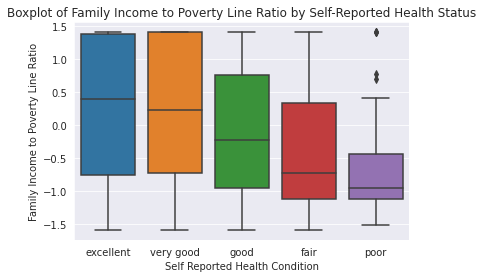

In [96]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

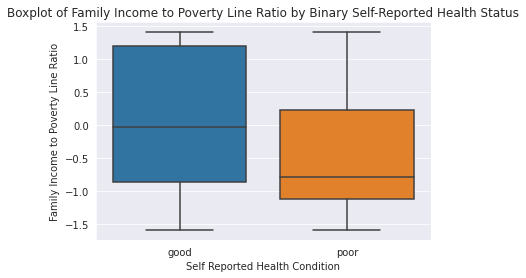

In [97]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

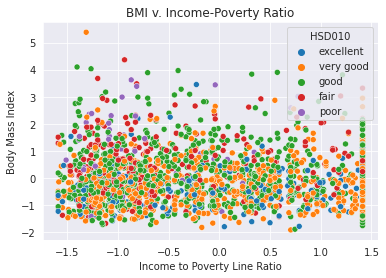

In [98]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [99]:
hsd010_binary = nhanes_scaled['HSD010_binary']
hsd010_binary

SEQN
73568    good
73576    good
73579    good
73581    good
73584    good
         ... 
83694    good
83696    good
83704    poor
83716    good
83721    good
Name: HSD010_binary, Length: 2064, dtype: object

In [100]:
y_num = nhanes_scaled.loc[:, 'HSD010'].replace(
    ['excellent', 'very good', 'good', 'fair', 'poor'], [1, 2, 3, 4, 5])
y = nhanes_scaled.loc[:,'HSD010']
y_bin = nhanes_scaled.loc[:,'HSD010_binary']

In [101]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis (Flavia Leite)

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [102]:
#performing a PCA on the features and summarizing them with 3 components.
pca = PCA(n_components=3)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

**Choice of the number of components:** We chose to keep 3 components since our main objective with PCA here is data vizualization. Considering that there is no particular meaning assigned to each principal component and to facilitate visualization, it makes sense to convert this high-dimensional data into a 3 dimensional one.

In [103]:
pca_df = pd.DataFrame(data = principalComponents_nhanes
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
pca_df.head()

,principal component 1,principal component 2,principal component 3
0,9.527811,-0.816228,-1.867397
1,-5.838339,-3.692574,3.806261
2,-0.719454,-2.573198,0.908098
3,3.533627,-2.576986,-3.248912
4,-6.872094,-4.194242,0.886514


### Barplot of Components

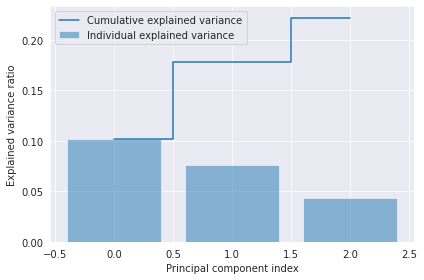

In [104]:
#Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### How many components will you use to fit a supervised learning model?

We decided to keep all components as they together contribute to explain more than 20% of the variance. While the first component contains 10% of the variance, the second principal component contains around 7%, and the third one 4% of the variance.

In [105]:
#Concatenating DataFrame before plotting the data.
pca_df['hsd010_binary'] = hsd010_binary.tolist()
pca_df

,principal component 1,principal component 2,principal component 3,hsd010_binary
0,9.527811,-0.816228,-1.867397,good
1,-5.838339,-3.692574,3.806261,good
2,-0.719454,-2.573198,0.908098,good
3,3.533627,-2.576986,-3.248912,good
4,-6.872094,-4.194242,0.886514,good
...,...,...,...,...
2059,2.643319,-1.689360,-0.702943,good
2060,1.037905,-0.118075,5.555715,good
2061,1.130254,-0.970426,3.415686,poor
2062,7.145092,-0.376758,1.752497,good


### 2D Scatterplot of the first two components

In [106]:
#Dropping the third component to plot the data
pca_df_two = pca_df.drop(['principal component 3'], axis = 1)
pca_df_two

,principal component 1,principal component 2,hsd010_binary
0,9.527811,-0.816228,good
1,-5.838339,-3.692574,good
2,-0.719454,-2.573198,good
3,3.533627,-2.576986,good
4,-6.872094,-4.194242,good
...,...,...,...
2059,2.643319,-1.689360,good
2060,1.037905,-0.118075,good
2061,1.130254,-0.970426,poor
2062,7.145092,-0.376758,good


<Figure size 432x288 with 0 Axes>

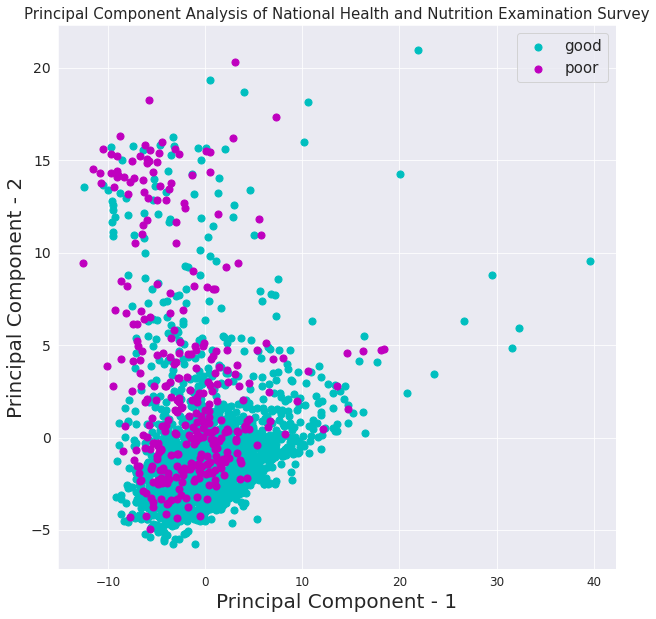

In [107]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of National Health and Nutrition Examination Survey",fontsize=15)
targets = ["good","poor"]
colors = ['c','m']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df_two['hsd010_binary'] == target
    plt.scatter(pca_df_two.loc[indicesToKeep, 'principal component 1']
               , pca_df_two.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

**Plot analysis:** The scatterplot does not show distinctive boundaries between the "poor" and "good" health classes, there is still a lot of overlap between them. Perhaps, we need a more sophisticated algorythim (such as neural networks?) to classify the data.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

We chose to use the k-means algorithm. The k-means algorithm is an unsupervised machine learning method that searches out a pre-defined amount of clusters within a dataset. It clusters points based on the "cluster center" which is the mean of all the points belonging to the cluster. 

### Cluster nhanes

In [108]:
#elbow method
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(nhanes_scaled)
    distortions.append(kmeanModel.inertia_)

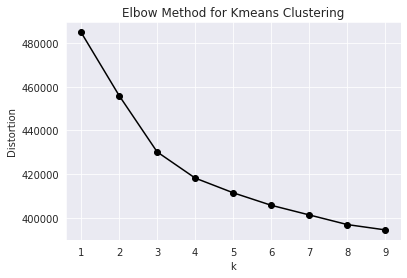

In [109]:
#plot elbow method results
plt.plot(K, distortions, 'ko-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Kmeans Clustering');

We used the elbow method to decide the number of clusters to use to train the k-means model. Based on the visual above, we decide that the "elbow" occurred at 3, so we will use 3 clusters when training the model below. 

In [110]:
#create the k-means model
#starting with 3 clusters based elbow method
kmeans = KMeans(n_clusters=3,
               max_iter=300 #default
               ).fit(nhanes_scaled)

In [111]:
print("Centers")
print(kmeans.cluster_centers_)
print()

print("Labels")
print(kmeans.labels_)
print()

for point, label in zip(nhanes_scaled, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 0.00000000e+00 -5.19935082e-02  0.00000000e+00  1.41420461e-01
   4.08189295e-02 -2.01031136e-01  1.95019476e-01  8.15681008e-02
  -1.25445255e-02 -4.94523331e-02 -7.22245376e-02 -1.63371759e-01
  -1.60466473e-01 -6.05526980e-02 -1.92093997e-01 -2.11891228e-01
  -1.00037323e-01  4.70539131e-02 -2.11208698e-01 -2.15309035e-01
  -1.55498409e-01 -2.16559758e-01 -2.27759744e-01 -8.77742609e-02
  -2.07329879e-01 -1.41107982e-01 -1.68324721e-01 -1.21254925e-01
  -4.07010421e-02 -1.99277051e-01 -1.19245993e-01 -1.69166539e-01
  -1.91854548e-01 -2.25618173e-01 -1.77460646e-01 -1.66049230e-01
  -2.17148446e-01 -9.26012598e-02 -1.67399856e-01 -2.41331729e-01
  -1.25338893e-01 -1.08110721e-01 -2.55803856e-01 -2.73214588e-01
  -2.10805666e-01 -1.76242005e-01 -1.92564353e-01 -2.03476696e-01
  -1.95062894e-01 -1.49459647e-01 -1.79875865e-01  1.46155936e-01
  -1.25401394e-01 -1.31387182e-01 -8.25853210e-02 -1.39218582e-01
  -1.19048515e-02 -1.39325326e-01 -1.78502997e-01 -1.34576173e-01
  

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

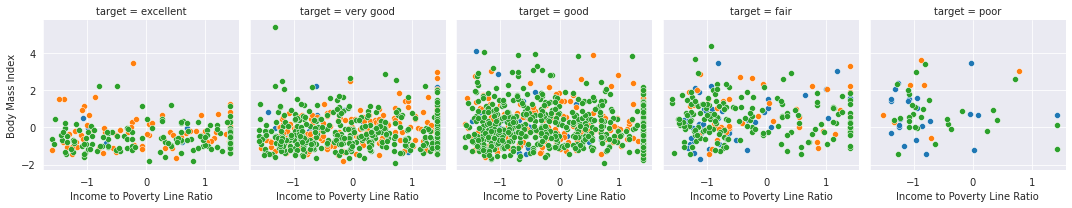

In [112]:
nhanes_scaled['kmean'] = kmeans.predict(nhanes_scaled)
nhanes_scaled['target'] = y
nhanes_scaled['target_bin'] = y_bin


#plotting
sea = sns.FacetGrid(nhanes_scaled, col = "target", hue = "kmean")
sea.map(sns.scatterplot, "INDFMPIR", "BMXBMI")
sea.set(xlabel = "Income to Poverty Line Ratio", ylabel = "Body Mass Index")
plt.show()

It does not appear that the k-means algorithm was successful in creating meaningful clusters. It is not obvious where the centroids for each of the three clusters would be located, or even where the boundaries of the clusters might be to begin with. 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [113]:
#Drop target variables to retrain algorithm
nhanes_scaled = nhanes_scaled.drop(['target', 'target_bin'], axis = 1)

In [114]:
#Code to train PCA with two components based on above findings
pca = PCA(n_components=2)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

In [115]:
#Creating dataframe
pca_df_retrain = pd.DataFrame(data = principalComponents_nhanes
             , columns = ['principal component 1', 'principal component 2',])
pca_df_retrain.head()

,principal component 1,principal component 2
0,9.534053,-0.905899
1,-5.900801,-3.621783
2,-0.767976,-2.582113
3,3.521594,-2.553112
4,-6.938943,-4.096143


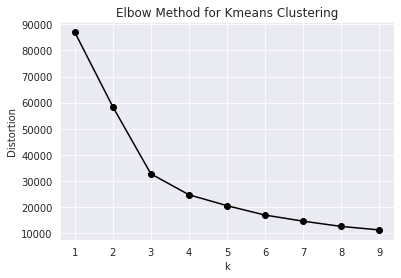

In [116]:
#create new k-means model based on PCA

#elbow method
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(pca_df_retrain)
    distortions.append(kmeanModel.inertia_)

#plot elbow method results
plt.plot(K, distortions, 'ko-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for Kmeans Clustering');

In [117]:
kmeans = KMeans(n_clusters=3,
               max_iter=300 #default
               ).fit(pca_df_retrain)

In [118]:
pca_df_retrain['kmean'] = kmeans.predict(pca_df_retrain)
poverty = nhanes_scaled['INDFMPIR'].reset_index(drop = True)
bmi = nhanes_scaled['BMXBMI'].reset_index(drop = True)
y.reset_index(drop = True, inplace = True)
y_bin.reset_index(drop = True, inplace = True)
# add columns to pca_df
pca_df_retrain['INDFMPIR'] = poverty
pca_df_retrain['BMXBMI'] = bmi
pca_df_retrain['target'] = y
pca_df_retrain['target_bin'] = y_bin

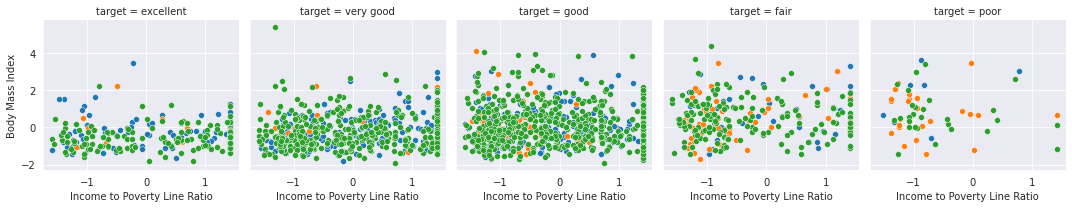

In [119]:
#plotting
sea = sns.FacetGrid(pca_df_retrain, col = "target", hue = "kmean")
sea.map(sns.scatterplot, "INDFMPIR", "BMXBMI")
sea.set(xlabel = "Income to Poverty Line Ratio", ylabel = "Body Mass Index")
plt.show()

In [73]:
pca_df_retrain = pca_df_retrain.drop(['target', 'target_bin', 'INDFMPIR', 'BMXBMI', 'kmean'], axis = 1)

Retraining the k-means algorithm on the PCA data did not help us to better predict the target variable. In both cases it does not look like the k-means clustering method worked very well. This may indicate that the data is not well suited to this machine learning technique. Regardless of the target variable's outcome, there is no ability to visually distinguish between the 3 clusters. This may be explained by looking at the scatterplot of family income with BMI--the data points have no discernible pattern, and overlap each other at every point. Attempting to separate this into clusters may not be particularly successful. 

## Neural Network (Peter Soyster)

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

In [120]:
#Reload dataset
# Load nhanes data
nhanes = pd.read_csv("https://raw.githubusercontent.com/dlab-berkeley/Computational-Social-Science-Training-Program/main/Projects/Project%204/nhanes.csv",
                                               low_memory=False)

# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()
nhanes_scaled.shape

y = nhanes_scaled['HSD010']# either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled.drop(['HSD010'], axis = 1) # drop out any columns that aren't features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [121]:
import keras
from keras.utils import np_utils 


# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]

In [122]:
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(
    Dense(6, input_dim= 241, activation= 'relu')
)

model.add(
    Dense(6, activation= 'relu')
)


model.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=.1), metrics=['accuracy'])

model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, batch_size=200, verbose=2)

#Evaluate model

scores = model.evaluate(X_test, y_test, verbose=0)
print("Model Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
8/8 - 1s - loss: 3.0127 - accuracy: 0.2500 - val_loss: 2.0894 - val_accuracy: 0.1899 - 720ms/epoch - 90ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2267 - accuracy: 0.1344 - val_loss: 2.2063 - val_accuracy: 0.1492 - 73ms/epoch - 9ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2578 - accuracy: 0.1389 - val_loss: 2.3491 - val_accuracy: 0.1357 - 78ms/epoch - 10ms/step
Epoch 4/10
8/8 - 0s - loss: 2.3164 - accuracy: 0.1286 - val_loss: 2.3819 - val_accuracy: 0.1163 - 69ms/epoch - 9ms/step
Epoch 5/10
8/8 - 0s - loss: 2.3745 - accuracy: 0.0762 - val_loss: 2.5268 - val_accuracy: 0.0213 - 64ms/epoch - 8ms/step
Epoch 6/10
8/8 - 0s - loss: 2.4507 - accuracy: 0.0381 - val_loss: 2.4897 - val_accuracy: 0.0174 - 52ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 2.3917 - accuracy: 0.0310 - val_loss: 2.4441 - val_accuracy: 0.0640 - 48ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 2.3655 - accuracy: 0.0814 - val_loss: 2.3945 - val_accuracy: 0.0775 - 63ms/epoch - 8ms/step
Epoch 9/10
8/8 - 0s - loss: 2.3465 - 

### Neural Network on Principal Components

In [123]:
pca_df['hsd010_binary'] =pca_df['hsd010_binary'].replace({'good':1,'poor':0})
#Define training and testing datasets
y = pca_df['hsd010_binary']
X = pca_df.drop(['hsd010_binary'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#Run the model
model_pca = Sequential()

model_pca.add(
    Dense(2, input_dim= 3, activation= 'relu')
)

model_pca.add(
    Dense(2, activation= 'relu')
)


model_pca.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=.1), metrics=['accuracy'])

model_pca.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, batch_size=200, verbose=2)

#Evaluate model

scores = model_pca.evaluate(X_test, y_test, verbose=0)
print("Model PCA Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
8/8 - 1s - loss: 3.3578 - accuracy: 0.6848 - val_loss: 2.2327 - val_accuracy: 0.8178 - 716ms/epoch - 89ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2494 - accuracy: 0.8127 - val_loss: 1.8847 - val_accuracy: 0.8295 - 47ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 1.7988 - accuracy: 0.8417 - val_loss: 1.5738 - val_accuracy: 0.8488 - 68ms/epoch - 8ms/step
Epoch 4/10
8/8 - 0s - loss: 1.7120 - accuracy: 0.8391 - val_loss: 1.5504 - val_accuracy: 0.8488 - 44ms/epoch - 5ms/step
Epoch 5/10
8/8 - 0s - loss: 1.6802 - accuracy: 0.8359 - val_loss: 1.5638 - val_accuracy: 0.8469 - 56ms/epoch - 7ms/step
Epoch 6/10
8/8 - 0s - loss: 1.7851 - accuracy: 0.8379 - val_loss: 1.9895 - val_accuracy: 0.8372 - 50ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 2.1901 - accuracy: 0.8224 - val_loss: 2.1127 - val_accuracy: 0.8236 - 42ms/epoch - 5ms/step
Epoch 8/10
8/8 - 0s - loss: 2.2800 - accuracy: 0.8127 - val_loss: 2.1600 - val_accuracy: 0.8198 - 42ms/epoch - 5ms/step
Epoch 9/10
8/8 - 0s - loss: 2.2858 - a

### Neural Network on Principal Components + Cluster Membership

---



In [124]:
#Define training and testing datasets
y = pca_df['hsd010_binary'] 
X = pca_df.drop(columns=['hsd010_binary'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

#Run the model
model_pcac = Sequential()

model_pcac.add(
    Dense(2, input_dim= 3, activation= 'relu')
)

model_pcac.add(
    Dense(2, activation= 'relu')
)


model_pcac.compile(loss= 'binary_crossentropy', optimizer=Adam(learning_rate=.1), metrics=['accuracy'])

model_pcac.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, batch_size=200, verbose=2)

#Evaluate model

scores = model_pcac.evaluate(X_test, y_test, verbose=0)
print("Model PCA-Cluster Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
8/8 - 1s - loss: 5.1780 - accuracy: 0.5504 - val_loss: 3.5652 - val_accuracy: 0.8023 - 733ms/epoch - 92ms/step
Epoch 2/10
8/8 - 0s - loss: 2.9993 - accuracy: 0.8107 - val_loss: 2.3253 - val_accuracy: 0.8217 - 62ms/epoch - 8ms/step
Epoch 3/10
8/8 - 0s - loss: 2.5497 - accuracy: 0.8353 - val_loss: 2.4467 - val_accuracy: 0.8275 - 62ms/epoch - 8ms/step
Epoch 4/10
8/8 - 0s - loss: 2.5462 - accuracy: 0.8430 - val_loss: 2.4319 - val_accuracy: 0.8469 - 61ms/epoch - 8ms/step
Epoch 5/10
8/8 - 0s - loss: 2.5194 - accuracy: 0.8346 - val_loss: 2.4015 - val_accuracy: 0.8488 - 42ms/epoch - 5ms/step
Epoch 6/10
8/8 - 0s - loss: 2.4784 - accuracy: 0.8359 - val_loss: 2.3506 - val_accuracy: 0.8488 - 46ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 2.4559 - accuracy: 0.8359 - val_loss: 2.3579 - val_accuracy: 0.8488 - 48ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 2.4710 - accuracy: 0.8359 - val_loss: 2.3854 - val_accuracy: 0.8488 - 46ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 2.4821 - a

Adding cluster membership did not change model accuracy. Our results indicaded that including the intial neural network worked best of the three neural network models. 

## Discussion Questions (Wan Nurul Naszeerah)

1. In your own words, what is the difference between PCA and clustering?

PCA is the process of reducing high dimensions into a few layers of key features. In short, it groups variables.

Clustering is the process of assigning data inputs with similar features to a specific group. In short, it groups observations.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

In general, by combining PCA and clustering, we can have a better sense of the big data and see otherwise unseen patterns. However, cluster quality is not necessarily improved by conducting clustering with the PCA-derived variables compared to with the original variables. The gains are also not apparent because of the way we choose to reduce the dimensionality of our data. 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques require less manual data preparation, which means we would be able to find previously unknown patterns in unlabeled big data automatically. For data with consistency, it is possible to create reliable workflows with high levels of labeling accuracy.

Hence, starting with unsupervised techniques can help us be more efficient and effective in the downstream supervised learning tasks. However, to be effective with the downstream process, we need to acknowledge that unsupervised learning can be expensive and that the training sessions may be longer and consume more power than supervised learning, especially with high volume data that use higher impact methods such as those in neural networks.